In [25]:
import numpy as np
import pandas as pd
from collections import Counter
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [9]:
#load data

data = pd.read_csv('PNQ_AQI.csv')
data.head()

,Date,SO2 µg/m3,Nox µg/m3,RSPM µg/m3,SPM,CO2 µg/m3,AQI,Location
0,2009-01-01 00:00:00,15,53,179.0,NaN,NaN,153.0,MPCB-KR
1,2009-02-01 00:00:00,15,48,156.0,NaN,NaN,137.0,MPCB-KR
2,2009-03-01 00:00:00,13,51,164.0,NaN,NaN,143.0,MPCB-KR
3,2009-04-01 00:00:00,8,37,135.0,NaN,NaN,123.0,MPCB-KR
4,2009-07-01 00:00:00,13,36,140.0,NaN,NaN,127.0,MPCB-KR


In [10]:
#check data

data.info()
print()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7844 entries, 0 to 7843
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        7844 non-null   object 
 1   SO2 µg/m3   7844 non-null   object 
 2   Nox µg/m3   7844 non-null   object 
 3   RSPM µg/m3  7843 non-null   float64
 4   SPM         2970 non-null   float64
 5   CO2 µg/m3   0 non-null      float64
 6   AQI         7787 non-null   float64
 7   Location    7844 non-null   object 
dtypes: float64(4), object(4)
memory usage: 490.4+ KB



Date             0
SO2 µg/m3        0
Nox µg/m3        0
RSPM µg/m3       1
SPM           4874
CO2 µg/m3     7844
AQI             57
Location         0
dtype: int64

In [11]:
data.shape

(7844, 8)

In [12]:
#Change Date strings to numbers and sort by date

data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by=['Date'], inplace=True, ignore_index=True)

In [13]:
#After doing some Googling, we found that BDL means "below detection limit".
#So we did the following:
#       -> Create a new feature of BDL for each column with such values
#       -> Extract the last 3 characters of each row (giving NA or a number)
#       -> Replace NA with 0 and convert the numbers to integers

for _, col in enumerate(list(data.columns[1:3])):
    data[f'{col} BDL'] = data[f'{col}'].map(lambda x: 1 if 'BDL' in x else 0)
    data[f'{col}'] = data[f'{col}'].apply(lambda x: x[-3:])
    data[f'{col}'] = data[f'{col}'].apply(lambda x: 0 if 'NA' in x else int((re.findall(r'\d+',x))[0]))

In [15]:
# Pick and show outliers

outlier_features = list(data.columns[1:5])
def detect_outliers(df,n,features):
    outlier_indices = []
    
    for col in features:
        q1 = np.nanpercentile(df[col], 25)
        q3 = np.nanpercentile(df[col], 75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr
        outlier_list_col = df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers

Outliers_to_drop = detect_outliers(data,1,outlier_features)
data.loc[Outliers_to_drop]

,Date,SO2 µg/m3,Nox µg/m3,RSPM µg/m3,SPM,CO2 µg/m3,AQI,Location,SO2 µg/m3 BDL,Nox µg/m3 BDL
1242,2010-12-28,65,128,372.0,NaN,NaN,328.0,MPCB-KR,0,0
1588,2011-07-12,52,60,300.0,555.0,NaN,250.0,MPCB-BSRI,0,0
1665,2011-08-24,56,60,239.0,735.0,NaN,193.0,MPCB-BSRI,0,0
1771,2011-10-26,54,142,225.0,NaN,NaN,183.0,MPCB-KR,0,0
1840,2011-12-01,95,85,237.0,618.0,NaN,191.0,MPCB-BSRI,0,0
1876,2011-12-21,59,52,271.0,417.0,NaN,221.0,MPCB-BSRI,0,0
1889,2011-12-28,59,85,267.0,610.0,NaN,217.0,MPCB-BSRI,0,0
1930,2012-01-14,60,75,285.0,406.0,NaN,235.0,Bhosari,0,0
1941,2012-01-18,61,71,307.0,454.0,NaN,257.0,Bhosari,0,0
4709,2014-12-23,53,9,280.0,NaN,NaN,230.0,Karve Road,0,0


In [16]:
# Remove outliers

data.drop(Outliers_to_drop, axis = 0, inplace=True)

In [17]:
# Delete multiple names for locations

rep={'MPCB-KR':'Karve Road','MPCB-SWGT':'Swargate','MPCB-BSRI':'Bhosari',\
     'MPCB-NS':'Nal Stop','MPCB-PMPR':'Pimpri','Pimpri Chinchwad':'Chinchwad'}
data['Location'].replace(rep,inplace=True)

In [18]:
#       -> Drop rows where AQI is NaN
#       -> Drop the column without relevant data (C02 has NaN values only)
#       -> Fill NaNs with nearest values

data.dropna(axis=0, subset=['AQI'], inplace=True)
data.drop(['CO2 µg/m3'], axis=1, inplace=True)
data.fillna(method='bfill', axis=0, inplace=True)

In [19]:
# Move AQI to beginning 
# Describe the dataset

data = data[['AQI'] + [c for c in data if c not in ['AQI']]]
data.describe()

,AQI,SO2 µg/m3,Nox µg/m3,RSPM µg/m3,SPM,SO2 µg/m3 BDL,Nox µg/m3 BDL
count,7749.000000,7749.000000,7749.000000,7749.000000,7749.000000,7749.000000,7749.000000
mean,101.309846,22.737902,52.983611,103.052523,224.831720,0.013034,0.021680
std,43.380645,14.152758,29.450625,57.007840,119.834609,0.113427,0.145647
min,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,66.000000,14.000000,32.000000,57.000000,123.000000,0.000000,0.000000
50%,100.000000,20.000000,48.000000,94.000000,220.000000,0.000000,0.000000
75%,131.000000,29.000000,70.000000,141.000000,304.000000,0.000000,0.000000
max,713.000000,525.000000,323.000000,680.000000,796.000000,1.000000,1.000000


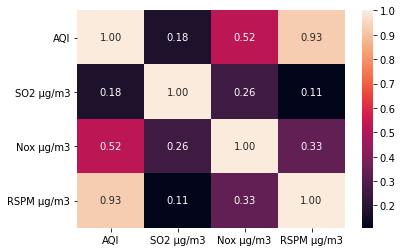

In [20]:
# Showing the correlation between numerical features and the target variable

c1 = sns.heatmap(data.iloc[:,:5].corr(),annot=True, fmt = ".2f")

#Note: All are positively correlated with the AQI, the strongest correlation is with Respirable Suspended Particulate Matter

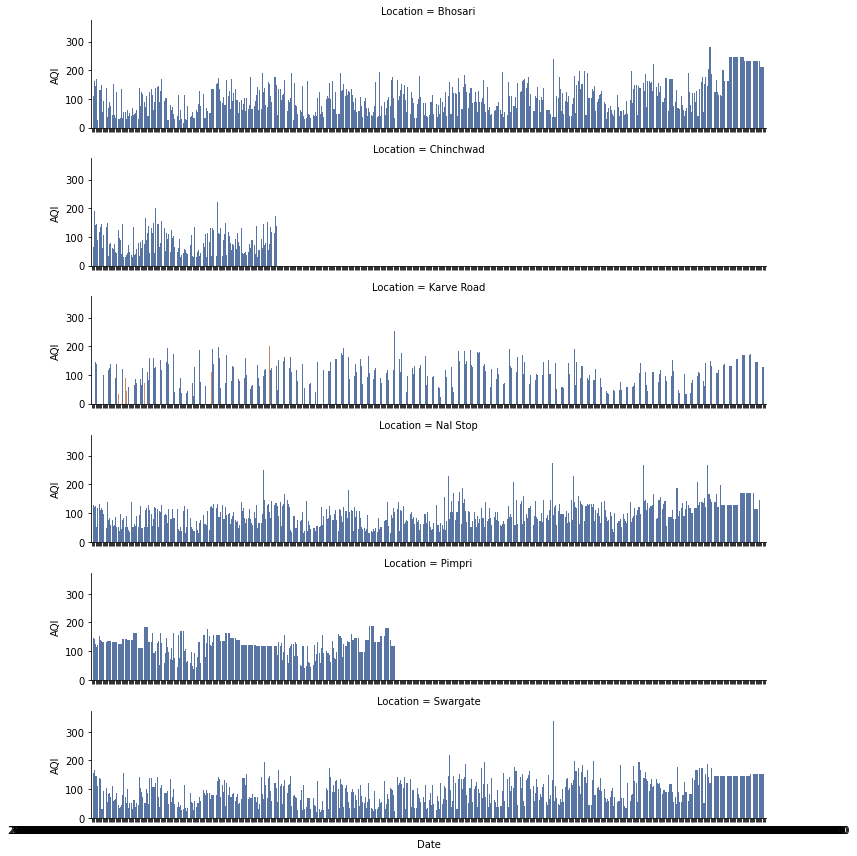

In [21]:
#Now, we need to find correlations between non-numeric features

date_sampler = data.set_index('Date').groupby('Location').resample('W').bfill().droplevel(0).reset_index()
c2 = sns.FacetGrid(date_sampler, row='Location', height=2, aspect=6)
c2.map(sns.barplot, 'Date', 'AQI', 'SO2 µg/m3 BDL', palette='deep')

#Note: # AQI got generally worse later in the timeframe, in some regions. But this is not reliable because most of the locations don't have data wrt the timeframe. 

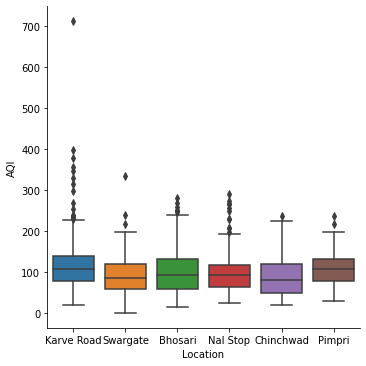

In [22]:
# Now, wrt location only

c3 = sns.factorplot(y="AQI",x="Location", data=data,kind="box")

#Note:
#       ->Here we see that Chinchwad has the greatest variation in AQI
#       ->Karve Road has a few outliers in terms of AQI, but this didn't draastically change its median AQI compared to the                     other locations
#       ->These points indicate a slight correlation between location and AQI

In [23]:
# Turn the Locations into categories, that is, creating dummy variables for each location
Location = pd.get_dummies(data.Location, prefix='Location')
frames = [data, Location]
data = pd.concat(frames, axis=1)
data.drop(columns=['Location'], inplace=True)

In [24]:
#       -> Separate data from target attribute
#       -> Create train and test sets (without dates)
#       -> scale the data

target = data.AQI
data.drop(['AQI'], axis=1, inplace=True)
X_train, X_test, y_train, y_test\
    = train_test_split(data.iloc[:,1:], target, test_size=0.25, random_state=42)

Xscaler = preprocessing.RobustScaler().fit(X_train)
X_train_transformed = Xscaler.transform(X_train)
X_test_transformed = Xscaler.transform(X_test)
yscaler = preprocessing.RobustScaler().fit(y_train.to_frame())
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
y_train_transformed = yscaler.transform(y_train.to_frame())
y_test_transformed = yscaler.transform(y_test.to_frame())

In [41]:
#       ->Build a simple model
#       ->Perform cross-validation on the training set
#       ->Predict and calculate the mean square error and absolute square error on the test

reg = LinearRegression().fit(X_train_transformed, y_train_transformed)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(reg, X_train_transformed, y_train_transformed, cv=cv)#computing the score for n splits

array([0.85977805, 0.85260162, 0.86255607, 0.85344087, 0.86453105])

In [42]:
y_pred = reg.predict(X_test_transformed)
print(mean_absolute_error(y_test_transformed, y_pred))
print()
print(mean_squared_error(y_test_transformed, y_pred))

0.0020621925242958546

7.416951790090037e-06


In [43]:
reg.score(X_train_transformed,y_train_transformed)

0.846036476539192

In [44]:
reg.score(X_test_transformed,y_test_transformed)

0.8509322740555036